In [212]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
# Add parent directory to path to import from sibling directories
sys.path.insert(0, str(Path().resolve().parent))
from dataset.cifar10 import load_cifar10, CIFAR10_CLASSES

from softmax_loss import softmax_loss

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
# Load raw CIFAR-10
X_train, y_train, X_test, y_test = load_cifar10(flatten_images=True, normalize=False)

# Convert from uint8 [0..255] → float32 [0..1]
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

print("Train:", X_train.shape, "Test:", X_test.shape)


✓ Found existing CIFAR-10 data at: C:\Users\vrpia\OneDrive\Documents\cs231n-deep-learning-for-computer-vision\code\dataset\cifar10\data\cifar-10-batches-py
  Using existing dataset files (no download needed).
Loaded CIFAR-10 dataset:
  Training set: 50000 images, shape (50000, 3072)
  Test set: 10000 images, shape (10000, 3072)
Train: (50000, 3072) Test: (10000, 3072)


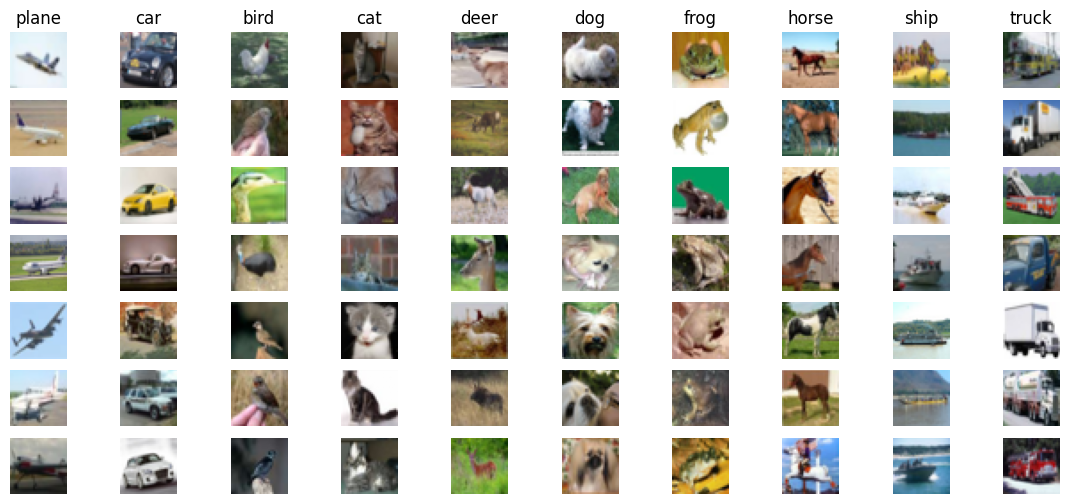

In [214]:
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(classes)
samples_per_class = 7

def reshape_image(flat_image):
    img = flat_image.reshape(3,32,32).transpose(1,2,0)
    return img

plt.figure(figsize=(14,6))

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(reshape_image(X_train[idx]))
        plt.axis("off")
        if i == 0:
            plt.title(cls)

plt.show()


In [215]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Validation split
X_val = X_train[num_training : num_training + num_validation]
y_val = y_train[num_training : num_training + num_validation]

# Training split
X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Dev set
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Test split (first 1000)
X_test = X_test[:num_test]
y_test = y_test[:num_test]

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)
print("Dev:  ", X_dev.shape)


Train: (49000, 3072)
Val:   (1000, 3072)
Test:  (1000, 3072)
Dev:   (500, 3072)


[0.2876793  0.28383943 0.28309754 0.28223464 0.2811159  0.28040174
 0.27964997 0.2793457  0.27854753 0.27842084]


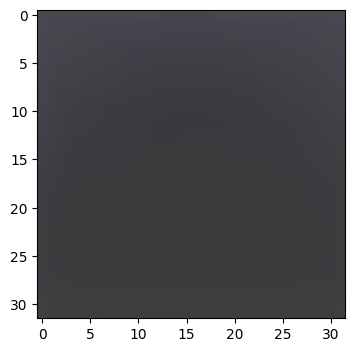

In [216]:
# Compute pixel-wise mean and std over training set
mean_image = np.mean(X_train, axis=0)
std_image  = np.std(X_train, axis=0)

# Avoid division by zero (important!)
std_image[std_image < 1e-8] = 1e-8
print(std_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(reshape_image(std_image)) # visualize the std image
plt.show()


[0.51232    0.5100241  0.51357174 0.515628   0.51801956 0.5206599
 0.52272356 0.5247841  0.527116   0.528832  ]


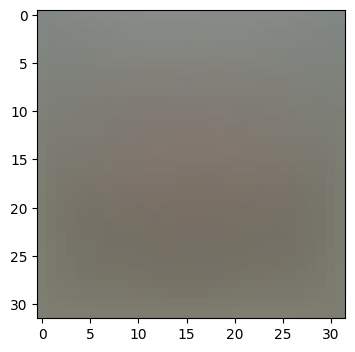

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [217]:
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(reshape_image(mean_image)) # visualize the mean image
plt.show()

# center the images
X_train = (X_train - mean_image)
X_val   = (X_val   - mean_image)
X_test  = (X_test  - mean_image)
X_dev   = (X_dev   - mean_image)


# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

In [218]:
import importlib
import sys

# Force reload the module
if 'linear_classifier' in sys.modules:
    del sys.modules['linear_classifier']

from linear_classifier import Softmax
import time

softmax = Softmax(learning_rate=2e-4)
tic = time.time()
loss_hist = softmax.train(X_train, y_train, reg=1e2, num_iters=1000, verbose=True)
toc = time.time()
print('Training time: %fs' % (toc - tic))


iteration 100 / 1000: loss 5.084639
iteration 200 / 1000: loss 2.345290
iteration 300 / 1000: loss 2.297434
iteration 400 / 1000: loss 2.296003
iteration 500 / 1000: loss 2.295808
iteration 600 / 1000: loss 2.296045
iteration 700 / 1000: loss 2.294649
iteration 800 / 1000: loss 2.297535
iteration 900 / 1000: loss 2.294015
iteration 1000 / 1000: loss 2.297222
Training time: 5.315531s


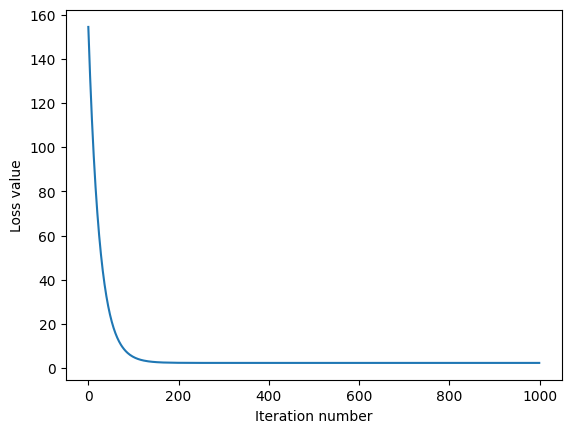

In [219]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [220]:
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.238755
validation accuracy: 0.260000


In [221]:
softmax.save("softmax.npy")

softmax.npy saved.


In [222]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.365 (> 0.36) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1.0e-02]
regularization_strengths = [1.0e-03]

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create Softmax and train it 
    softmax = Softmax(learning_rate=lr)
    softmax.train(X_train, y_train, reg, num_iters=3000)

    # Compute training and validation sets accuracies and append to the dictionary
    y_train_pred, y_val_pred = softmax.predict(X_train), softmax.predict(X_val)
    results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)
    print(lr, reg, results[(lr, reg)])

    # Save if validation accuracy is the best
    if results[(lr, reg)][1] > best_val:
        best_val = results[(lr, reg)][1]
        best_softmax = softmax


# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

0.01 0.001 (np.float64(0.4075714285714286), np.float64(0.406))
lr 1.000000e-02 reg 1.000000e-03 train accuracy: 0.407571 val accuracy: 0.406000
best validation accuracy achieved during cross-validation: 0.406000


In [224]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.385000


### Tiny subset (overfitting)

Let's train on a very small subset to verify that our softmax function is operational

In [223]:
num_examples = 200
mask = np.random.choice(X_train.shape[0], num_examples, replace=False)
X_small = X_train[mask]
y_small = y_train[mask]

softmax = Softmax(learning_rate=1e-2)  # adjust if needed
loss_hist = softmax.train(
    X_small, y_small,
    reg=0.0,
    num_iters=5000,
    batch_size=200,
    verbose=True
)

y_small_pred = softmax.predict(X_small)
print("tiny subset train accuracy:", np.mean(y_small_pred == y_small))


iteration 100 / 5000: loss 1.660561
iteration 200 / 5000: loss 1.297227
iteration 300 / 5000: loss 1.262104
iteration 400 / 5000: loss 1.112609
iteration 500 / 5000: loss 0.985265
iteration 600 / 5000: loss 0.891252
iteration 700 / 5000: loss 0.793130
iteration 800 / 5000: loss 0.752910
iteration 900 / 5000: loss 0.714694
iteration 1000 / 5000: loss 0.667824
iteration 1100 / 5000: loss 0.593144
iteration 1200 / 5000: loss 0.581099
iteration 1300 / 5000: loss 0.518245
iteration 1400 / 5000: loss 0.516151
iteration 1500 / 5000: loss 0.511548
iteration 1600 / 5000: loss 0.430180
iteration 1700 / 5000: loss 0.439999
iteration 1800 / 5000: loss 0.437404
iteration 1900 / 5000: loss 0.403557
iteration 2000 / 5000: loss 0.348757
iteration 2100 / 5000: loss 0.352363
iteration 2200 / 5000: loss 0.330321
iteration 2300 / 5000: loss 0.307140
iteration 2400 / 5000: loss 0.289752
iteration 2500 / 5000: loss 0.294510
iteration 2600 / 5000: loss 0.268290
iteration 2700 / 5000: loss 0.272669
iteration 

## Takeaways

- We searched for hyperparameters in a very poor way, starting a with huge regularization factors. As a result, most of our loss goes into the regularization term and we are rewarded by choosing a uniform $W$.
- Appling mean **and standard deviation** normalization can help keep the results in a better conditioned space.
- There were a couple of steps we used to validate our implementation:
    - Gradient check
    - More detailed view of the probability outputs, gradient norm
    - Fitting on a small subset
